In [1]:
from __future__ import (absolute_import, division, print_function,unicode_literals)
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
# Import the backtrader platform
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds

In [3]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('period', 20),('dev', 2.0)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.bband = btind.BollingerBands(self.datas[0], period = self.p.period, devfactor = self.p.dev)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        if self.order:
            return
        if not self.position:
            if self.data.close < self.bband.lines.bot:
                self.log('BUY CREATE(LONG), %.2f' % self.data.close[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
                
            elif self.data.close > self.bband.lines.top:
                self.log('SELL CREATE(SHORT), %.2f' % self.data.close[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
        else:
            if self.position.size>0 and self.data.close > self.bband.lines.mid:
                self.log('SELL CREATE(SHORT), %.2f' % self.data.close[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
            if self.position.size < 0 and self.data.close <= self.bband.lines.mid:
                self.log('BUY CREATE(LONG), %.2f' % self.data.close[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

Starting Portfolio Value: 100000.00
2000-02-25, SELL CREATE(SHORT), 31.41
2000-02-28, SELL EXECUTED, Price: 31.69, Cost: -316.90, Comm 3.17
2000-03-30, BUY CREATE(LONG), 34.88
2000-03-31, BUY EXECUTED, Price: 35.66, Cost: -316.90, Comm 3.57
2000-03-31, OPERATION PROFIT, GROSS -39.70, NET -46.43
2000-04-14, BUY CREATE(LONG), 27.80
2000-04-17, BUY EXECUTED, Price: 26.91, Cost: 269.10, Comm 2.69
2000-04-27, SELL CREATE(SHORT), 34.38
2000-04-28, SELL EXECUTED, Price: 34.91, Cost: 269.10, Comm 3.49
2000-04-28, OPERATION PROFIT, GROSS 80.00, NET 73.82
2000-05-23, BUY CREATE(LONG), 27.85
2000-05-24, BUY EXECUTED, Price: 27.47, Cost: 274.70, Comm 2.75
2000-05-30, SELL CREATE(SHORT), 32.99
2000-05-31, SELL EXECUTED, Price: 32.58, Cost: 274.70, Comm 3.26
2000-05-31, OPERATION PROFIT, GROSS 51.10, NET 45.09
2000-07-05, BUY CREATE(LONG), 32.16
2000-07-06, BUY EXECUTED, Price: 31.91, Cost: 319.10, Comm 3.19
2000-07-20, SELL CREATE(SHORT), 34.75
2000-07-21, SELL EXECUTED, Price: 34.44, Cost: 319.10,

<IPython.core.display.Javascript object>


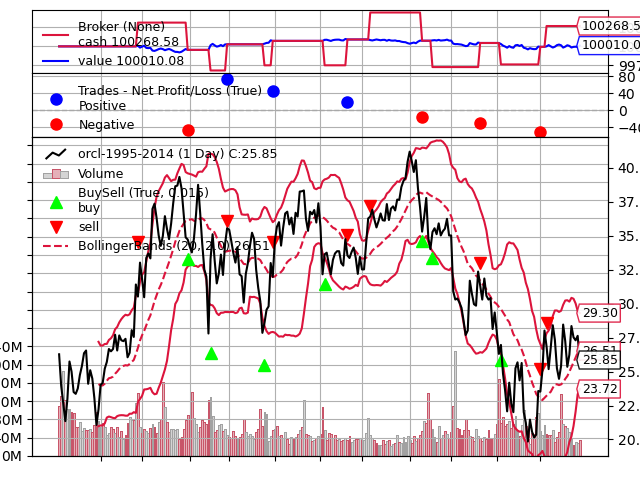

In [4]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, '/home/aayush/anaconda3/lib/python3.8/site-packages/orcl-1995-2014.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2000, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2000, 12, 31),
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)
    cerebro.addstrategy(TestStrategy)
    cerebro.addsizer(bt.sizers.SizerFix, stake=10)
    # Set our desired cash start
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.01)
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot()